In [1]:
# Matplotlib dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# pandas, numpy and date dependencies
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Declare a base using automap_base()
Base = automap_base()

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)
# Alternative statement on some other versions
# reflect the tables

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table: Assign class to variable
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
measurement_tbl = session.query(Measurement)
station_tbl = session.query(Station)

In [10]:
# Inspect the tables
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
most_recent_date.__dict__["date"]

'2017-08-23'

2016-08-23
            Date  Precipitation
0     2016-08-23            0.0
1009  2016-08-23            NaN
1529  2016-08-23           45.5
704   2016-08-23            1.3
361   2016-08-23            3.8
...          ...            ...
1527  2017-08-22            0.0
1008  2017-08-23            0.0
360   2017-08-23            0.0
1528  2017-08-23            2.0
2229  2017-08-23           11.4

[2230 rows x 2 columns]


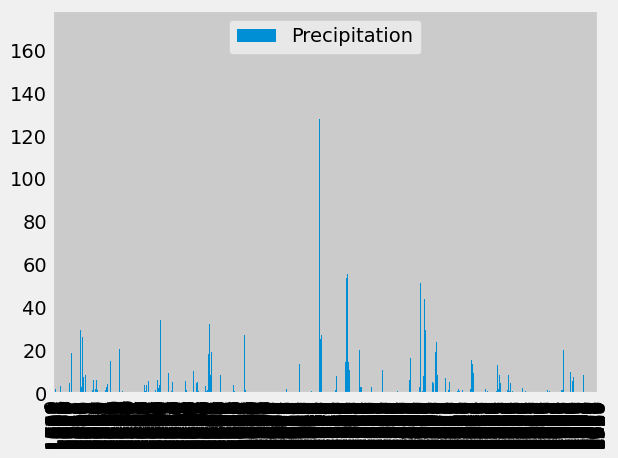

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_ago)
# Perform a query to retrieve the data and precipitation scores
ex_prcp_ana = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
# print(ex_prcp_ana)
# Save the query results as a Pandas DataFrame and set the index to the date column
ex_prcp_ana_data = [{"Date": row[0], "Precipitation": row[1]} for row in ex_prcp_ana]
# print(ex_prcp_ana_data)
# Sort the dataframe by date
# ex_prcp_ana_df = pd.DataFrame(ex_prcp_ana_data).set_index("Date").sort_values(["Date"])
ex_prcp_ana_df = pd.DataFrame(ex_prcp_ana_data).sort_values(["Date"])
print(ex_prcp_ana_df)
ex_prcp_ana_df.to_csv('ex_prcp_ana_df.csv')



# Use Pandas Plotting with Matplotlib to plot the data
# ex_prcp_ana_df
ex_prcp_ana_df.plot.bar()
plt.tight_layout()
plt.show()


<BarContainer object of 2230 artists>

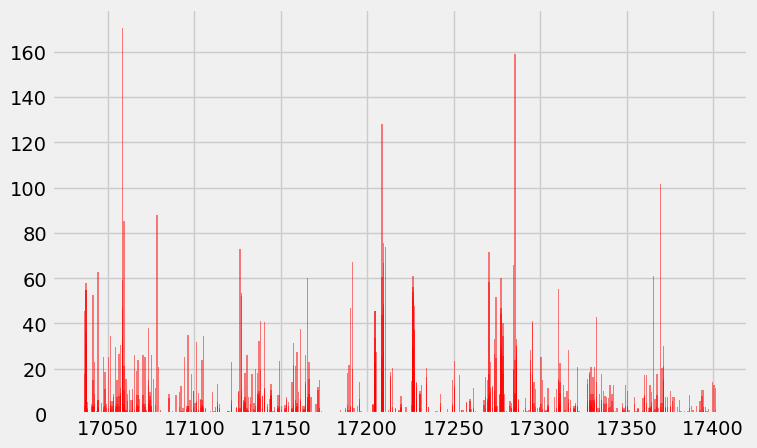

In [22]:
plt.figure(figsize=(8,5))
plt.bar(mdates.datestr2num(ex_prcp_ana_df["Date"]), ex_prcp_ana_df["Precipitation"], color='r', alpha=0.5, align="edge")
# plt.xticks(tick_locations, ex_prcp_ana_df["Date"], rotation="vertical")

In [20]:
type(ex_prcp_ana_df["Date"].iloc[0])

str

In [21]:
import matplotlib.dates as mdates

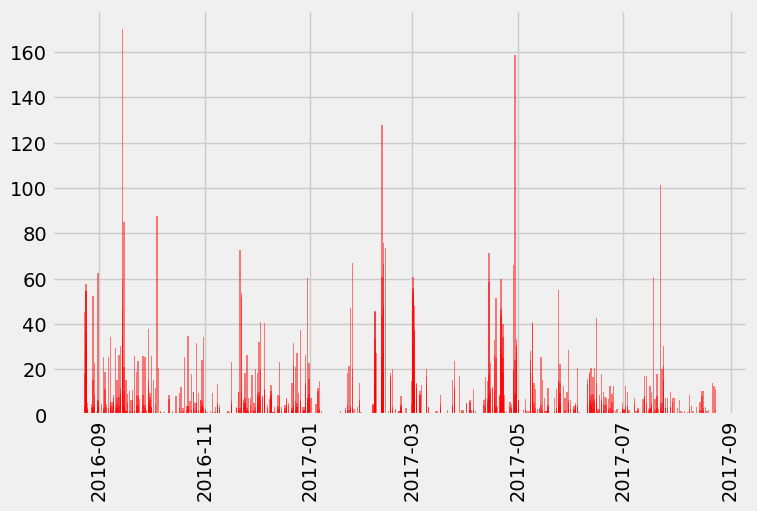

In [25]:
plt.figure(figsize=(8,5))
plt.bar(pd.to_datetime(ex_prcp_ana_df["Date"]), ex_prcp_ana_df["Precipitation"], color='r', alpha=0.5, align="edge")
# plt.xticks(tick_locations, ex_prcp_ana_df["Date"], rotation="vertical")
plt.xticks(rotation=90)
plt.show()

In [75]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [113]:
# Design a query to calculate the total number stations in the dataset
# Number of unique stations
unique_station_count =  session.query(Station).count()
print(f"The number of unique weather stations is: {unique_station_count}.")
# from sqlalchemy import distinct
# station_count =  session.query(func.count(distinct(Measurement.station)))

rows = session.query(func.count(Measurement.station)).scalar()
print(rows)
station_count =  session.query(Measurement).order_by("station").count()
print(f"The total number of station measurements for the {unique_station_count} stations are: {station_count}.")

The number of unique weather stations is: 9.
19550
The total number of station measurements for the 9 stations are: 19550.


In [131]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_activity = [Measurement.station, 
    func.count(Measurement.date), Station.name]
list_station_count = session.query(*station_activity).filter(Measurement.station == Station.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
list_station_count

#Note: data above is not based on precipitation. there were some NULL values.
# while values are NULL the stations was still used to collect TOBS data

[('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00519397', 2724, 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 2709, 'KANEOHE 838.1, HI US'),
 ('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00517948', 1372, 'PEARL CITY, HI US'),
 ('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US')]

In [190]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# stats_for_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
#     filter(Measurement.station == "USC00519281").all()
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
# stats_for_active_station
print(f"The lowest temperature was {min_temp[0]}, the maximum temperature was {max_temp[0]}, and the average temperature was {avg_temp[0]}.")
# most_active_data1 = [{"Date": row[0], "Precipitation": row[1]} for row in most_active_data]
# print(most_active_data1)
# Sort the dataframe by date
# most_active_data1_df = pd.DataFrame(most_active_data1)
# most_active_data1_df


The lowest temperature was (12.2,), the maximum temperature was (29.4,), and the average temperature was (22.03582251082252,).


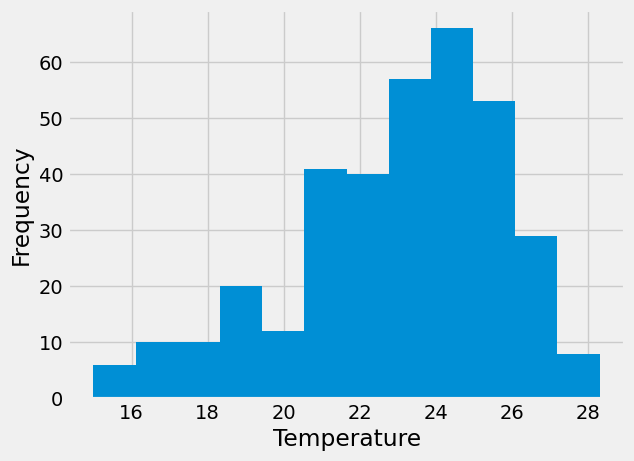

In [194]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == "USC00519281").all()
# print(last_year_temp)
last_year_temperature = [{"Temperature": row[0]} for row in last_year_temp]

last_year_temperature_df = pd.DataFrame(last_year_temperature)
# last_year_temperature_df

plt.hist(last_year_temperature_df['Temperature'], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()



In [195]:
# # Using the most active station id
# # Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# last_year = session.query(Measurement.tobs, func.count(Measurement.date)).\
#     filter(Measurement.date >= year_ago).\
#     filter(Measurement.station == "USC00519281").\
#     group_by(Measurement.tobs).all()
# print(last_year)


In [196]:
# last_year_data = [{"Temperature": row[0], "Frequency": row[1]} for row in last_year]
# # print(ex_prcp_ana_data)
# # Sort the dataframe by date
# last_year_data_df = pd.DataFrame(last_year_data)
# # print(last_year_data_df)
# # bins
# bins = [14.9,16.2,17.4,18.6,19.8,21,22.2,23.4,24.6,25.8,27,28.3]
# # bin labels
# group_labels =[15,16.2,17.4,18.6,19.8,21,22.2,23.4,24.6,25.8,27]
# last_year_data_df["binned_temperature"] = pd.cut(last_year_data_df["Temperature"], bins, labels=group_labels)
# last_year_data_df
# Data_for_graph = last_year_data_df.groupby("binned_temperature")["Frequency"].sum()
# Data_for_graph_df = Data_for_graph.to_frame()
# # Data_for_graph_df = Data_for_graph["Frequency"].sum()
# Data_for_graph_df
# Data_for_graph_df.to_csv('Data_for_graph_df.csv')

In [197]:
# # Using the most active station id
# # Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# last_year_new = session.query(Measurement.tobs, Measurement.date).\
#     filter(Measurement.date >= year_ago).\
#     filter(Measurement.station == "USC00519281").all()
# print(last_year_new)


In [198]:
# last_year_new_data = [{"Temperature": row[0], "Date": row[1]} for row in last_year_new]
# # print(ex_prcp_ana_data)
# # Sort the dataframe by date
# last_year_new_data_df = pd.DataFrame(last_year_new_data)

# last_year_new_data_df.to_csv('last_year_new_data_df.csv')
# # print(last_year_new_data_df)
# # bins
# bins = [15,16.2,17.4,18.6,19.8,21,22.2,23.4,24.6,25.8,27,28.2,29.4]
# # bin labels
# group_labels =[15,16.2,17.4,18.6,19.8,21,22.2,23.4,24.6,25.8,27,28.2]
# last_year_new_data_df["binned_temperature"] = pd.cut(last_year_new_data_df["Temperature"], bins, labels=group_labels)
# last_year_new_data_df
# last_year_new_data_df.to_csv('last_year_new_data_df2.csv')
# # new_data_for_graph = last_year_new_data_df.groupby("binned_temperature")["Frequency"].sum()
# # new_data_for_graph_df = new_data_for_graph.to_frame()
# # # Data_for_graph_df = Data_for_graph["Frequency"].sum()
# # Data_for_graph_df

In [199]:
# plt.hist(last_year_new_data_df['Temperature'], bins = 12)
# plt.xlabel('Temperature')
# plt.ylabel('Frequency')
# plt.show()

# Close session

In [ ]:
# Close Session
session.close()